# Visualize the video

In [2]:
# Display the reconstruction video
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                      <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

!ffmpeg -y -hide_banner -loglevel error -i PHALP_vid.mp4 PHALP_vid_ffmpg.mp4
show_local_mp4_video('PHALP_vid_ffmpg.mp4', width=960, height=540)

In [3]:
from IPython.display import Video

#Video("vid.mp4")


In [4]:
import joblib
results = joblib.load("demo_vid.pkl")

In [141]:
import numpy as np

number_of_frames = len(results)


l2_distances = np.zeros(number_of_frames)  # Array to hold L2 distance for each frame
left_ankles = np.zeros((number_of_frames, 2))   # Array to hold left ankle 2D coordinates for each frame
right_ankles = np.zeros((number_of_frames, 2))  # Array to hold right ankle 2D coordinates for each frame

boundary_boxes = np.zeros((number_of_frames, 4)) 
#print(boundary_boxes)

for frame_number, frame_key in enumerate(sorted(results.keys())):
    frame_data = results[frame_key]
    #print(frame_data['bbox'][0])
    #print(frame_data["tid"])

    # Add boundary box data from each frame
    boundary_boxes[frame_number] = frame_data['tracked_bbox'][0]
    #print(len(frame_data['tracked_bbox']) )

    # Assuming '3d_joints' provides the 3D joint locations
    left_ankle_3d = np.array(frame_data['3d_joints'][0][7])
    right_ankle_3d = np.array(frame_data['3d_joints'][0][8])

    # Calculate L2 distance using the 3D coordinates
    l2_distance = np.linalg.norm(right_ankle_3d - left_ankle_3d)

    l2_distances[frame_number] = l2_distance

    # Assuming '2d_joints' provides the 2D projections of the 3D joints
    # Extracting the 2D coordinates for the left and right ankles
    left_ankle_2d = frame_data['2d_joints'][0][14 : 14+2]
    right_ankle_2d = frame_data['2d_joints'][0][14+2 : 14+2+2]

    # Add the 2D coordinates to the arrays
    left_ankles[frame_number] = left_ankle_2d
    right_ankles[frame_number] = right_ankle_2d

[ 7 43]
0.3493480980396271 2 0.04 1.2 0.4192177176475525 1.509183783531189


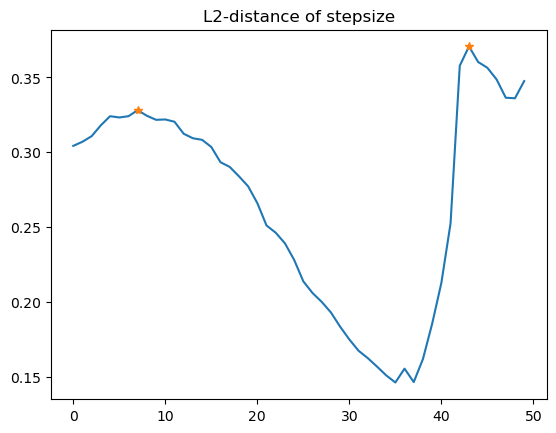

In [149]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import cv2
# Open the video
cap = cv2.VideoCapture('PHALP_vid.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
durationInSeconds = totalNoFrames // fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

local_maxima_indices = argrelextrema(l2_distances,np.greater,order=10)[0]
local_maxima_values = l2_distances[local_maxima_indices]
print(local_maxima_indices)

mean_stride = np.mean(local_maxima_values)

total_number_of_steps = len(local_maxima_indices)

average_steps_per_frame = total_number_of_steps / totalNoFrames

average_steps_per_second = average_steps_per_frame * fps

distance_per_second = average_steps_per_second * mean_stride
km_hour = distance_per_second * 3.6
print(mean_stride, total_number_of_steps, average_steps_per_frame, average_steps_per_second,distance_per_second, km_hour)

plt.title("L2-distance of stepsize")
plt.plot(l2_distances)
plt.plot(local_maxima_indices,local_maxima_values,"*")


In [152]:
import cv2

# Open the video
cap = cv2.VideoCapture('PHALP_vid.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
step_count = 0
# If you need to convert an entire list of normalized coordinates:
left_ankles_pixels = left_ankles * np.array([width, height])
right_ankles_pixels = right_ankles * np.array([width, height])
#print(right_ankles_pixels)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('PHALP_vid_l2.mp4', fourcc, fps, (width, height))

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_number < len(l2_distances):
        # Draw a line between the left and right ankles
        left_ankle = tuple(map(int, left_ankles_pixels[frame_number]))
        right_ankle = tuple(map(int, right_ankles_pixels[frame_number]))
        cv2.line(frame, left_ankle, right_ankle, (255, 0, 0), 2)

        # Display boundary box
        scale = 1440/1920 # Get scaling factor through dividing new by old dimensions of video
        x,y,w,h = boundary_boxes[frame_number] * scale
        start_point = (int(x),int(y))
        end_point = (int((x+w)) ,int((y+ h)))
        #print(end_point)
        cv2.rectangle(frame, start_point, end_point, (255, 0, 0), 2)

        # Display the L2 distance
        l2_distance = l2_distances[frame_number]
        text = f"L2 distance: {l2_distance:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*1)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display steps taken
        if (frame_number in local_maxima_indices):
            step_count += 1
        
        text = f"Steps taken: {step_count:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*2)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display Speed

        # Display idx of boundary box


    out.write(frame)
    frame_number += 1

# Release everything when job is finished
cap.release()
out.release()


In [153]:
!ffmpeg -y -hide_banner -loglevel error -i PHALP_vid_l2.mp4 PHALP_vid_l2_ffmpg.mp4
show_local_mp4_video('PHALP_vid_l2_ffmpg.mp4', width=960, height=540)